In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/predicting_secondary_structure_of_protein/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Préparation des données

In [ ]:
def read_protein_sequences(filename):
    sequences = []
    current_sequence = []

    with open(filename, "r") as file:
        for line in file:
            line = line.strip()

            if line == "<>":
                if current_sequence:
                    sequences.append(current_sequence)
                current_sequence = []
                continue

            if line == "<end>":
                if current_sequence:
                    sequences.append(current_sequence)
                current_sequence = []
                continue

            if not line or line.startswith("#"):
                continue

            parts = line.split()
            if len(parts) == 2:
                aa, ss = parts
                current_sequence.append((aa, ss))

    if current_sequence:
        sequences.append(current_sequence)

    return sequences

In [ ]:
train = read_protein_sequences(path+"protein-secondary-structure.train")
test = read_protein_sequences(path+"protein-secondary-structure.test")

In [ ]:
print(f"Train : ", len(train), " paires " , "|" , "Test :", len(test), " paires ")

Train :  111  paires  | Test : 17  paires 


In [ ]:
# 20 acides aminés + caractère vide "<s>"
acides_amines = [
    "A", "C", "D", "E", "F", "G", "H", "I", "K", "L",
    "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "<s>"
]
# Dictionnaire {lettre: index}
aa_to_index = {aa: i for i, aa in enumerate(acides_amines)}

# 3 structures secondaires en one-hot
structure_secondaire = {'h' : (1,0,0), 'e' : (0,1,0), '_' : (0,0,1) }

print(aa_to_index)

{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '<s>': 20}


In [ ]:
# Fonction de sliding window + encodage
def sliding_window_encoding(sequence, window_size=5):
    assert window_size % 2 == 1, "La taille de la fenêtre doit être impaire"
    padding_size = window_size // 2

    # Padding de la séquence avec des <s> et _ : on met un début et un fin
    padded_sequence = [('<s>', '_')] * padding_size + sequence + [('<s>', '_')] * padding_size

    inputs = []
    targets = []

    for i in range(len(sequence)):
        window = padded_sequence[i:i+window_size]  # Longueur 5
        letters = [aa_to_index[aa] for aa, _ in window] # De lettres à chiffres grâce à aa_to_index
        center_structure = padded_sequence[i + padding_size][1]

        # One-hot pour les lettres (21 dim) → concaténées (5 × 21 = 105)
        letter_tensor = torch.tensor(letters, dtype=torch.long)
        one_hot_letters = F.one_hot(letter_tensor, num_classes=len(acides_amines)).flatten()

        # One-hot pour la structure centrale (3 dim)
        structure_tensor = torch.tensor(structure_secondaire[center_structure], dtype=torch.float32)

        inputs.append(one_hot_letters)
        targets.append(structure_tensor)

    # Convertir en batch de tenseurs
    X = torch.stack(inputs)  # (nb_fenêtres, 105)
    y = torch.stack(targets)  # (nb_fenêtres, 3)
    return X, y

In [ ]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

####  Encodage par fenêtre glissante

In [ ]:
# Encodage sliding window sur toutes les séquences
def encode_all_sequences(sequences):
    all_X = []
    all_y = []
    # Pour chaque séquence
    for seq in sequences:
        # Encodage sliding window
        X, y = sliding_window_encoding(seq)
        # Ajouter aux données X et y
        all_X.append(X)
        all_y.append(y)
    # On retourne
    return torch.cat(all_X, dim=0), torch.cat(all_y, dim=0)

# Génération des ensembles

# Entraînement
X_train, y_train = encode_all_sequences(train)

# test
X_test_raw, y_test_raw = encode_all_sequences(test)

# extraction de 20% de l'ensemble de test pour validation
X_test, X_val, y_test, y_val = train_test_split(
    X_test_raw, y_test_raw, test_size=0.2, random_state=42
)

# coup d'oeil
print("Taille X_train :", X_train.shape)
print("Taille y_train :", y_train.shape)
print("Taille X_test  :", X_test.shape)
print("Taille y_test  :", y_test.shape)
print("Taille X_val   :", X_val.shape)
print("Taille y_val   :", y_val.shape)

Taille X_train : torch.Size([18104, 105])
Taille y_train : torch.Size([18104, 3])
Taille X_test  : torch.Size([2816, 105])
Taille y_test  : torch.Size([2816, 3])
Taille X_val   : torch.Size([704, 105])
Taille y_val   : torch.Size([704, 3])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Fonction pour préparer les données encodées avec sliding window
def prepare_data(X_train, y_train, X_val, y_val, batch_size=128):
    # Conversion des données d'entraînement en TensorDataset et création du DataLoader
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Conversion des données de validation en TensorDataset et création du DataLoader
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

#### Encodage de séquences complètes pour le LSTM et préparation des données

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Fonction pour encoder des séquences complètes sans fenêtre glissante
def encode_full_sequences(sequences):
    X = []  # séquences d'acides aminés
    y = []  # séquences de structures secondaires (labels)

    # Pour chaque séquence
    for seq in sequences:

        # On l'encode directement

        # 1 - Encoder chaque acide aminé en indice numérique
        encoded_seq = [aa_to_index[aa] for aa, _ in seq]

        # 2 - Encoder chaque structure en index numérique (0,1,2)
        encoded_labels = [structure_secondaire[ss].index(1) for _, ss in seq]

        X.append(encoded_seq)
        y.append(encoded_labels)

    return X, y

# Fonction pour préparer les données pour le lstm
def prepare_data_for_lstm(train, test, batch_size=32, padding_value=20, label_padding=-100):

    # Encodage complet sans sliding window
    X_train_full, y_train_full = encode_full_sequences(train)
    X_test_full, y_test_full = encode_full_sequences(test)

    # Fonction pour gérer les tailles des séquences variables chez le lstm
    def pad_sequences(sequences, labels):
        max_len = max(len(seq) for seq in sequences)
        print(max_len)
        padded_seqs = []
        padded_labels = []

        # Pour chaque couple
        for seq, lab in zip(sequences, labels):
            # On crée autant de séquences à padder
            seq_padding = [padding_value] * (max_len - len(seq))
            # On les ajoutes
            padded_seqs.append(seq + seq_padding)

            # Pareil pour les labels
            lab_padding = [label_padding] * (max_len - len(lab))
            padded_labels.append(lab + lab_padding)

        return padded_seqs, padded_labels

    X_train_padded, y_train_padded = pad_sequences(X_train_full, y_train_full)
    X_test_padded, y_test_padded = pad_sequences(X_test_full, y_test_full)

    # Création des datasets
    train_dataset = TensorDataset(torch.tensor(X_train_padded), torch.tensor(y_train_padded))
    test_dataset = TensorDataset(torch.tensor(X_test_padded), torch.tensor(y_test_padded))

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
train_loader, test_loader = prepare_data_for_lstm(train, test, batch_size=64)

497
461


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

#### On définit trois modèles : MLP, récurrents et LSTM

In [ ]:
# Modèle MLP
class MLPModel(nn.Module):
    def __init__(self, input_dim=105, hidden_dim=64, output_dim=3):
        super(MLPModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


# Modèle RNN
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(105, 100, num_layers=2, nonlinearity="tanh",batch_first=True, dropout=0.3)
        self.fc = nn.Linear(100, 3)

    def forward(self, x):
        x = x.view(-1, 1, 105)
        output, _ = self.rnn(x)
        return self.fc(output[:, -1])


# Modèle LSTM : On va l'entraîner avec des séquences complètes
class LSTMModel(nn.Module):
    def __init__(self, vocab_size=21, embedding_dim=256, hidden_dim=200, output_dim=3):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=20)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, cn) = self.lstm(x)
        return self.fc(output)


#### Entraînement

In [ ]:
import torch.optim as optim

# On définit trois optimiseurs
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD, 'rmsprop': optim.RMSprop}

In [ ]:
# Fonction pour entraîner les modèles non LSTM

def train_model(model, train_loader, val_loader, optimizer_name='adam', lr=0.01, epochs=5):
    # Vérification des optimiseurs disponibles
    optimizers = {
        'adam': torch.optim.Adam,
        'sgd': torch.optim.SGD,
        'rmsprop': torch.optim.RMSprop
    }

    # Sélection de l'optimiseur
    if optimizer_name.lower() in optimizers:
        optimizer = optimizers[optimizer_name.lower()](model.parameters(), lr=lr)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not recognized. Choose from {list(optimizers.keys())}.")

    # Fonction de perte
    criterion = nn.CrossEntropyLoss()

    # Déplacer le modèle et la fonction de perte au GPU si disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)

    # Entraînement
    model.train()
    for epoch in range(epochs):
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Remise à zéro des gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Conversion des labels one-hot en indices si nécessaire
            if labels.dim() > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)

            # Calcul de la perte et rétropropagation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Afficher les informations d'entraînement
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Évaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Conversion des labels one-hot en indices si nécessaire
            if labels.dim() > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')
    return accuracy

#### Fonction pour entraîner un LSTM

In [ ]:
# Fonction pour entraîner le LSTM
def train_lstm_full_sequences(model, train_dataset, val_dataset, optimizer_name='adam', lr=0.001, epochs=10, batch_size=32):
    # Dataloaders pour les données
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Optimiseurs disponibles
    if optimizer_name.lower() not in optimizers:
        raise ValueError(f"Optimizer '{optimizer_name}' not recognized.")

    optimizer = optimizers[optimizer_name.lower()](model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for sequences, labels in train_loader:
            sequences = sequences.to(device).long()
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(sequences)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}")

    # Évaluation finale pour obtenir l'accuracy
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device).long()
            labels = labels.to(device)
            outputs = model(sequences)
            predictions = torch.argmax(outputs, dim=-1)
            mask = labels != -100
            correct += ((predictions == labels) & mask).sum().item()
            total += mask.sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
# X_train

In [ ]:
# y_train

In [ ]:
X_val

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
y_val

tensor([[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]])

In [ ]:
models = {'MLP': MLPModel(), 'RNN': RNNModel(), 'LSTM': LSTMModel()}

In [ ]:
# Fonction pour exécuter un modèle
def execute_model(model_name: str, optimizer_name: str, lr: float, window_size: int, epochs: int=100):
    if optimizer_name not in optimizers:
        raise ValueError(f"Optimizer '{optimizer_name}' not recognized. Choose from {list(optimizers.keys())}.")

    # Cas spécial pour LSTM
    if model_name == 'LSTM':
        train_loader, val_loader = prepare_data_for_lstm(train, test, batch_size=128)
        model = models[model_name]
        print(f"Training {model_name} model with {optimizer_name} optimizer using full sequences...")
        accuracy = train_lstm_full_sequences(model, train_loader.dataset, val_loader.dataset, optimizer_name, lr, epochs, batch_size=128)
        print(f"Accuracy of {model_name}: {accuracy:.2f}")
        return accuracy

    else:
        train_loader, val_loader = prepare_data(X_train, y_train, X_val, y_val, batch_size=128)
        model = models[model_name]
        print(f"Training {model_name} model with {optimizer_name} optimizer using window size {window_size}...")
        accuracy = train_model(model, train_loader, val_loader, optimizer_name, lr, epochs)
        print(f"Accuracy of {model_name}: {accuracy:.2f}")
        return accuracy

In [ ]:
# execute_model('MLP', 'adam', 0.001, 5, epochs=50)

In [ ]:
# execute_model('RNN', 'adam', 0.001, 5, 50)

In [ ]:
execute_model('LSTM', 'adam', 0.001, 5, 30)

497
461
Training LSTM model with adam optimizer using full sequences...
Epoch 1/30, Training Loss: 1.1012
Epoch 2/30, Training Loss: 1.0117
Epoch 3/30, Training Loss: 0.9596
Epoch 4/30, Training Loss: 0.9368
Epoch 5/30, Training Loss: 0.9274
Epoch 6/30, Training Loss: 0.9162
Epoch 7/30, Training Loss: 0.9033
Epoch 8/30, Training Loss: 0.8930
Epoch 9/30, Training Loss: 0.8851
Epoch 10/30, Training Loss: 0.8776
Epoch 11/30, Training Loss: 0.8694
Epoch 12/30, Training Loss: 0.8603
Epoch 13/30, Training Loss: 0.8500
Epoch 14/30, Training Loss: 0.8385
Epoch 15/30, Training Loss: 0.8277
Epoch 16/30, Training Loss: 0.8207
Epoch 17/30, Training Loss: 0.8165
Epoch 18/30, Training Loss: 0.8112
Epoch 19/30, Training Loss: 0.8045
Epoch 20/30, Training Loss: 0.7976
Epoch 21/30, Training Loss: 0.7927
Epoch 22/30, Training Loss: 0.7882
Epoch 23/30, Training Loss: 0.7835
Epoch 24/30, Training Loss: 0.7780
Epoch 25/30, Training Loss: 0.7727
Epoch 26/30, Training Loss: 0.7669
Epoch 27/30, Training Loss:

0.6102272727272727

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fonction pour faire plusiers exécutions et comparer
def execute_models_and_compare():
    models = ['MLP', 'RNN', 'LSTM']
    optimizers = ['adam', 'sgd', 'rmsprop']
    results = []

    for model_name in models:
        for optimizer_name in optimizers:
            print(f"Running {model_name} with {optimizer_name} optimizer...")
            accuracy = execute_model(model_name, optimizer_name, 0.001, 5, 20) # LE NOMBRE d'époch ne change rien pour le lstm
            results.append({
                'Model': model_name,
                'Optimizer': optimizer_name,
                'Accuracy': accuracy
            })

    # Création d'un DataFrame pour les résultats
    results_df = pd.DataFrame(results)

    # Visualisation avec seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Optimizer')
    plt.title('Comparative Accuracy of Models with Different Optimizers')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.legend(title='Optimizer')
    plt.show()

    return results_df

Running MLP with adam optimizer...
Training MLP model with adam optimizer using window size 5...
Epoch [1/20], Step [1/142], Loss: 1.1189
Epoch [1/20], Step [2/142], Loss: 1.1111
Epoch [1/20], Step [3/142], Loss: 1.0994
Epoch [1/20], Step [4/142], Loss: 1.1121
Epoch [1/20], Step [5/142], Loss: 1.1044
Epoch [1/20], Step [6/142], Loss: 1.0918
Epoch [1/20], Step [7/142], Loss: 1.1001
Epoch [1/20], Step [8/142], Loss: 1.0822
Epoch [1/20], Step [9/142], Loss: 1.0829
Epoch [1/20], Step [10/142], Loss: 1.0832
Epoch [1/20], Step [11/142], Loss: 1.0769
Epoch [1/20], Step [12/142], Loss: 1.0763
Epoch [1/20], Step [13/142], Loss: 1.0590
Epoch [1/20], Step [14/142], Loss: 1.0684
Epoch [1/20], Step [15/142], Loss: 1.0734
Epoch [1/20], Step [16/142], Loss: 1.0521
Epoch [1/20], Step [17/142], Loss: 1.0727
Epoch [1/20], Step [18/142], Loss: 1.0583
Epoch [1/20], Step [19/142], Loss: 1.0550
Epoch [1/20], Step [20/142], Loss: 1.0575
Epoch [1/20], Step [21/142], Loss: 1.0388
Epoch [1/20], Step [22/142], L

<ipython-input-40-867da078f61e>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
<ipython-input-40-867da078f61e>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Epoch [6/20], Step [52/142], Loss: 0.8815
Epoch [6/20], Step [53/142], Loss: 0.7580
Epoch [6/20], Step [54/142], Loss: 0.8420
Epoch [6/20], Step [55/142], Loss: 0.8866
Epoch [6/20], Step [56/142], Loss: 0.8073
Epoch [6/20], Step [57/142], Loss: 0.7708
Epoch [6/20], Step [58/142], Loss: 0.8505
Epoch [6/20], Step [59/142], Loss: 0.8397
Epoch [6/20], Step [60/142], Loss: 0.9297
Epoch [6/20], Step [61/142], Loss: 0.9252
Epoch [6/20], Step [62/142], Loss: 0.8777
Epoch [6/20], Step [63/142], Loss: 0.9072
Epoch [6/20], Step [64/142], Loss: 0.8245
Epoch [6/20], Step [65/142], Loss: 0.8194
Epoch [6/20], Step [66/142], Loss: 1.0560
Epoch [6/20], Step [67/142], Loss: 0.8818
Epoch [6/20], Step [68/142], Loss: 0.8255
Epoch [6/20], Step [69/142], Loss: 0.7092
Epoch [6/20], Step [70/142], Loss: 0.7841
Epoch [6/20], Step [71/142], Loss: 0.9438
Epoch [6/20], Step [72/142], Loss: 0.8390
Epoch [6/20], Step [73/142], Loss: 0.800

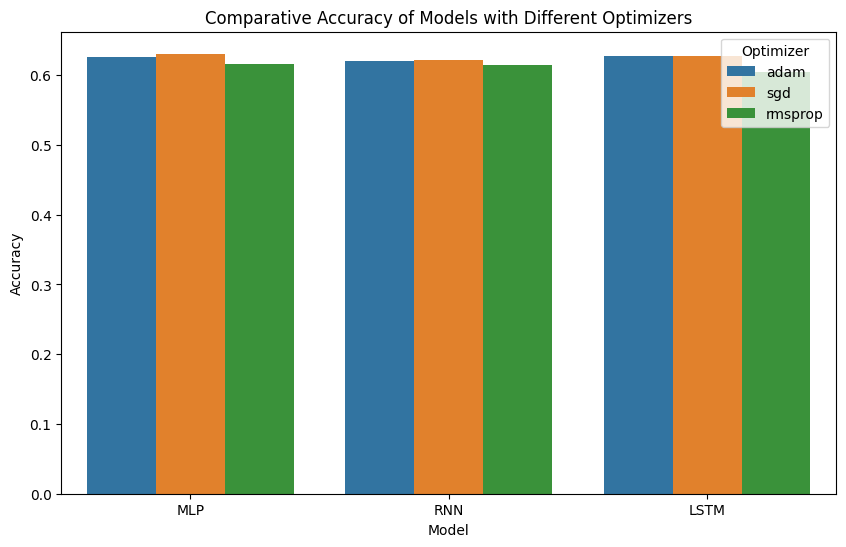

In [ ]:
results_multi_ex = execute_models_and_compare()

In [ ]:
results_multi_ex

,Model,Optimizer,Accuracy
0,MLP,adam,0.626420
1,MLP,sgd,0.630682
2,MLP,rmsprop,0.616477
3,RNN,adam,0.620739
4,RNN,sgd,0.622159
5,RNN,rmsprop,0.615057
6,LSTM,adam,0.626989
7,LSTM,sgd,0.627557
8,LSTM,rmsprop,0.604830


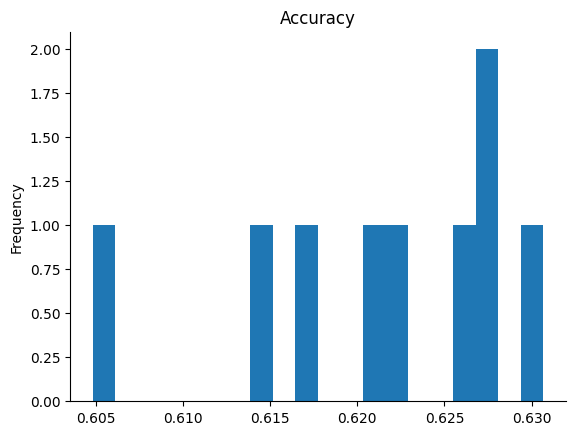

In [ ]:
# @title Accuracy

from matplotlib import pyplot as plt
results_multi_ex['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)